In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
columns = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
df = pd.read_csv("MAGIC Gamma Telescope.csv")

In [14]:
# Map class labels: gamma 'g' -> 1, hadron 'h' -> 0
df['class'] = df['class'].map({'g': 1, 'h': 0})

if df.isnull().sum().sum() > 0:
    print("Warning: Missing values found!")
else:
    print("No missing values.")

X = df.drop('class', axis=1)
y = df['class']

No missing values.


In [15]:
if df.isnull().sum().sum() > 0:
    print("Warning: Missing values found!")
else:
    print("No missing values.")

X = df.drop('class', axis=1)
y = df['class']

No missing values.


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set class distribution:")
print(y_train.value_counts(normalize=True))

Training set class distribution:
class
1    0.648396
0    0.351604
Name: proportion, dtype: float64


In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

In [19]:
param_grid = {
    'C': [0.01, 0.1, 0.5, 1, 5],
    'solver': ['liblinear', 'lbfgs'],
    'class_weight': ['balanced', None]
}

logreg = LogisticRegression(max_iter=1000, random_state=42)

grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_poly, y_train)
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best CV accuracy: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'C': 0.5, 'class_weight': None, 'solver': 'lbfgs'}
Best CV accuracy: 0.8582


In [20]:
best_model = grid_search.best_estimator_

In [21]:
y_pred = best_model.predict(X_test_poly)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Hadron', 'Gamma']))

Test set accuracy: 0.8541

Classification Report:
              precision    recall  f1-score   support

      Hadron       0.87      0.69      0.77      1338
       Gamma       0.85      0.94      0.89      2466

    accuracy                           0.85      3804
   macro avg       0.86      0.82      0.83      3804
weighted avg       0.86      0.85      0.85      3804



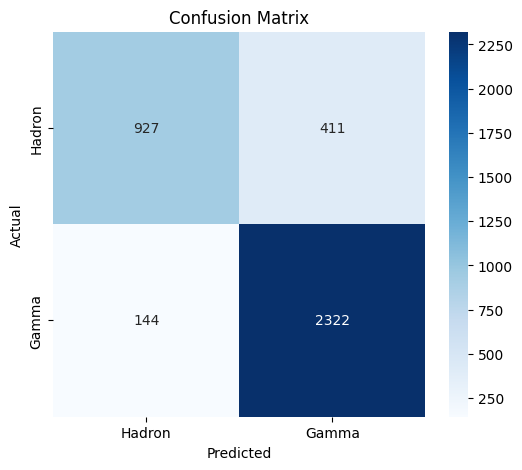

In [22]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hadron', 'Gamma'],
            yticklabels=['Hadron', 'Gamma'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Top Feature Importances (absolute coefficients):
fAlpha            1.822934
fLength           1.820060
fSize             1.802825
fConc             1.788425
fLength fSize     1.295177
fWidth fAlpha     1.283921
fWidth fConc      1.172639
fSize fConc       1.135680
fWidth fSize      1.087060
fSize fAlpha      0.853967
fWidth fConc1     0.796325
fSize fConc1      0.652694
fAlpha fDist      0.562397
fLength fDist     0.520070
fLength fConc     0.508441
fLength fAlpha    0.479516
fConc fAlpha      0.400007
fWidth fAsym      0.380739
fWidth fDist      0.281953
fWidth            0.263624
dtype: float64


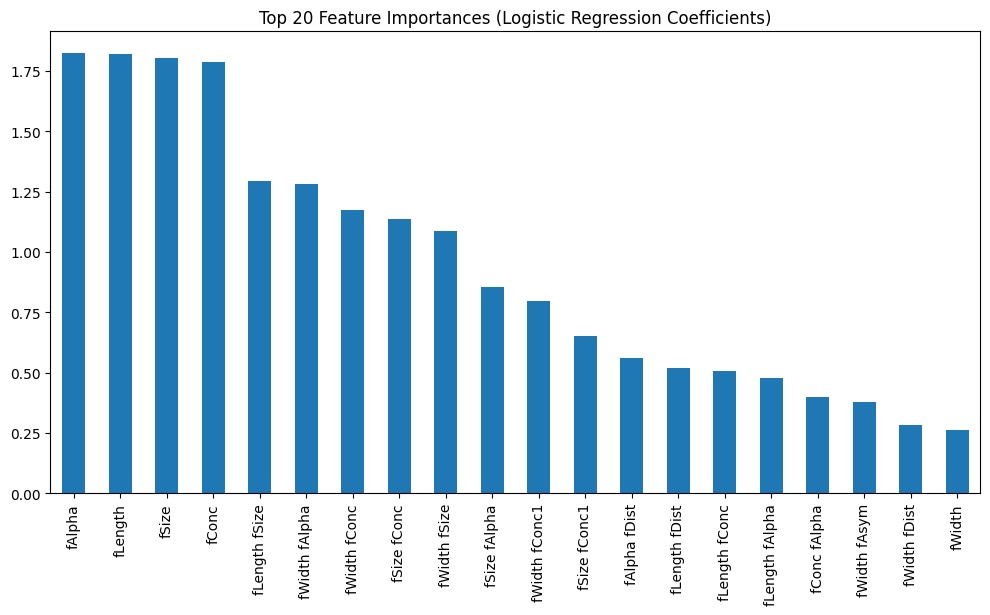

In [23]:
feature_names_poly = poly.get_feature_names_out(X.columns)

coefs = pd.Series(np.abs(best_model.coef_[0]), index=feature_names_poly)
coefs = coefs.sort_values(ascending=False)

print("Top Feature Importances (absolute coefficients):")
print(coefs.head(20))

plt.figure(figsize=(12, 6))
coefs.head(20).plot(kind='bar')
plt.title('Top 20 Feature Importances (Logistic Regression Coefficients)')
plt.show()